# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

## Introduction to the exercise
The goal of this exercise is to implement the simulation from exercise `Lezione_4` by adding a new sampling method within a new ensemble, the canonical ensemble, where the number of particles N the volume  V, and the temperature T are kept constant, in contrast to the microcanonical ensemble where the energy E is kept constant. This simulation models a system in natural units with the properties of a solid, liquid, and gas.

The first simulation described above is called LJ Monte Carlo (NVT) Simulation, while the second is called LJ Molecular Dynamics (NVE) Simulation, where LJ stands for Lennard-Jones potential, which represents the interaction potential between particles.

In particular, this exercise focuses on two main topics: the `radial distribution function g(r)` and the study of `autocorrelation` of the data generated by the random number generator.

## Information about the code 
Like in `Lezione_4` the exercise gives in an `input.dat` file the initial information that caracheterized the system. that could be resumed by the the table:

| Parameter       | Value |
|-----------------| ------|
| SIMULATION_TYPE | 0/1     |
| RESTART         | 0     |
| TEMP            | 0.95  |
| NPART           | 108   |
| RHO             | 0.05  |
| R_CUT           | 5.0   |
| DELTA           | 0.1|
| NBLOCKS         | 120   |
| NSTEPS          | 2000  |
| ENDINPUT        |       |

Where `SIMULATION_TYPE` refers to the type of simulation (in this case, a Lennard-Jones simulation); `RESTART` is used to determine whether to take and initialize velocity from a previous simulation; `TEMP` is the initial temperature; `NPART` is the number of particles; `RHO` is the particle density; `DELTA` is the time step between two steps; `NBLOCKS` is the number of blocks, and `NSTEPS` is the number of steps within each block.

Like in `Lezione_4`, I create two different input data files: the first one, used for equilibration, is `./INPUT/METHOD/PHASE/input_equilibration.dat`, and the second one, used for the production run, is `./INPUT/METHOD/PHASE/input.dat.` (method could be or MD(Molecular Dynamics simulation) or MC (Monte Carlo simulation)

In this exercise, `SIMULATION_TYPE = 0` is used for LJ Molecular Dynamics, and `SIMULATION_TYPE = 1` is used for LJ Monte Carlo. 

In particular, for the Monte Carlo simulation, the sampling method uses the `Metropolis` algorithm, which was also used in exercise `Lezione_6` for sampling the Ising model, with some differences. In this case, we are not interested in changing the spin but in proposing a movement of the particle and calculating the acceptance using the Boltzmann distribution $ \exp(-\beta \cdot \Delta E) $, where $\Delta E$ is the Lennard-Jones potential difference between the porpose `move()` and the old position

Here below I put part of the code:

- Porpose `move (int i -->(particle i)) ` and Metropolis Algorithm `metro()`

````cpp
  void System :: move(int i){ 
  [...]
  if(_sim_type == 1){       // LJ system
      vec shift(_ndim);       // Will store the proposed translation
      for(int j=0; j<_ndim; j++){
        shift(j) = _rnd.Rannyu(-1.0,1.0) * _delta; // uniform distribution in [-_delta;_delta)
      }
      _particle(i).translate(shift, _side);  //Call the function Particle::translate
      if(this->metro(i)){ //Metropolis acceptance evaluation
        _particle(i).acceptmove();
        _naccepted++;
      } else _particle(i).moveback(); //If translation is rejected, restore the old configuration
    } 

    bool System :: metro(int i){ // Metropolis algorithm
          bool decision = false;
          double delta_E, acceptance;
          if(_sim_type == 1) delta_E = this->Boltzmann(i,true) - this->Boltzmann(i,false);
          [...]
      if(_rnd.Rannyu() < acceptance ) decision = true; //Metropolis acceptance step
      return decision;
}
    
    
````
- Boltzmann potential:
````cpp
    double System :: Boltzmann(int i, bool xnew){
          double energy_i=0.0;
          double dx, dy, dz, dr;
          for (int j=0; j<_npart; j++){
            if(j != i){
              dx = this->pbc(_particle(i).getposition(0,xnew) - _particle(j).getposition(0,1), 0);
              dy = this->pbc(_particle(i).getposition(1,xnew) - _particle(j).getposition(1,1), 1);
              dz = this->pbc(_particle(i).getposition(2,xnew) - _particle(j).getposition(2,1), 2);
              dr = dx*dx + dy*dy + dz*dz;
              dr = sqrt(dr);
          if(dr < _r_cut){
            energy_i += 1.0/pow(dr,12) - 1.0/pow(dr,6);
          }
        }
      }
  return 4.0 * energy_i;
}
    
````
To compile the code see `Read.me`. About the organizion of the `OUTPUT` data, I create two path `OUTPUT/MC_NVT/phase` or `OUTPUT/MD_NVE/phase` in which i put the results requested by the exercise. **phase** could be equal to: **GAS,LIQUID,SOLID,AUTOCORRELATION**. Where in autocorrelation I put the result of autocorrelation analysis of the data.








## Radial Distribution Function g($\vec r$)

The radial distribution function $ g(r) $ is defined as the ratio between the local density of **n-particle** configurations and the product of single-particle densities. The denominator represents the free particle distribution, which is obtained by integrating the configurational distribution function over the positions of all particles except for one, incorporating the appropriate normalization factors.

It is essentially the ratio of the actual particle density at specific positions $\vec{r}_1, \dots, \vec{r}_n$ to the density predicted for a system of free particles at the same average density:

$$
g_{n}^{(N)}(\vec{r}_1, \dots, \vec{r}_n) = \frac{\rho (\vec{r}_1, \dots, \vec{r}_n)}{\prod_{i=1}^{n} \rho (\vec{r}_i)}
$$

where $\rho (\vec{r}_1, \dots, \vec{r}_n) = \frac{N!}{(N-n)!} \cdot \int{\vec{dr}_1, \dots, \vec{dr}_n \frac{e^{-\beta*(V(\vec{r}_1, \dots, \vec{r}_n))}}{Z}}$

where $V(\vec{r})$ is the potential.

In the case of two particles $(n = 2)$, the radial distribution function $g(r)$ represents the probability of finding a pair of atoms separated by a distance $r$, relative to the probability expected for non-interacting particles at the same overall density.

By calculating g(r), we can deduce how particles interact with one another:

- \(g(r) > 1\): Particles tend to stay together, indicating attractive interactions.
- \(g(r) < 1\): Particles are less likely to be near each other, suggesting repulsive interactions.
- \(g(r) = 1\): Particles are distributed uniformly, with no preference for attraction or repulsion.

Another important aspect of g(r) is that could be used to compute the ensemble average of any pair function like a 2-body potential v(r), obtaining, in a spherical coordinate:


$$
\langle V \rangle =2\pi \rho N \int_{0}^{\infty} dr r^2 v(r)* g(r)
$$



### Exercise 07.1
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$

### Tail corrections with g($\vec r$)
Using ensemble averaging of the system through \(g(r)\), it is possible to apply tail corrections to the quantities being estimated. In the program, a cutoff distance `r_cut` is used to truncate the calculations, assuming that beyond `r_cut`, (g(r) = 1). This assumption allows for the computation of tail corrections to the desired quantities, specifically for the potential energy U/N and the pressure P.

- Potential energy for particles:

$$
\frac{\langle U \rangle} {N} = 8\pi\epsilon\rho_{LJ}[ \frac{1}{9 r_{cut_{LJ}}^9}-\frac{1}{3 r_{cut_{LJ}}^3}]
$$

- Pressure:

$$
\frac{\langle W_{LJ} \rangle} {3N\epsilon} = 32\pi\rho_{LJ}[ \frac{1}{9 r_{cut_{LJ}}^9}-\frac{1}{6 r_{cut_{LJ}}^3}]
$$

where the subscript (LJ) means that are used reduce dimension.

#### code:
In the code I adjust the measurement of pressure and potential energy, adding these quantities called respectively `_ptail`and `_vtail`.


### Exercise 07.2

Use the NSL simulator code to <span style="color:red">print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations</span> (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

### Equilibration
Before printing instantaneous values during the equilibrated Monte Carlo simulation, it is necessary to set the acceptance of the Metropolis algorithm to 50%. To achieve this, in the function `metro()`, you should consider the moving shift by adjusting the `DELTA` parameter from the `input_equilibration.dat` file for the generation of the pourpose step. Therefore, it is important to modify this parameter to influence the acceptance rate.

For this reason, a function called `equilibration_fine()` is implemented, which measures the acceptance rate and decides to increase `DELTA` in `\INPUT\MC\PHASE\input_equilibration.dat` if the acceptance exceeds the threshold or to decrease it if it falls below 50%, and reached the aim, modifies `DELTA` in the file `\INPUT\MC\PHASE\input.dat`, ready for the evolution of the exercise.

```cpp

bool equilibration_fine(double att_Temp,double  counter){
    [...]

     if (_sim_type == 1){
      cout << "acceptance reached: " << _fr_accept << endl;
      cout << "delta read: " << _delta << endl;
      k = true; //if return true, I can stop the measure
      double delta_new= 0.;
        if (_fr_accept > 0.5 + 0.005){
          delta_new = _delta*1.01;
          modify_delta_input("../INPUT/"+ _phase +"/input_equilibration.dat", delta_new );
          k = false;

        }else if (_fr_accept < 0.5 - 0.005){
          delta_new = _delta*0.99;
          modify_delta_input("../INPUT/"+ _phase +"/input_equilibration.dat", delta_new );
          k = false;
        } else if (_fr_accept > 0.5 - 0.005 && _fr_accept < 0.5 + 0.005 ){
          modify_delta_input("../INPUT/"+ _phase +"/input.dat", _delta );
          k = true;
        }
}
```
The argument (double att_Temp,double  counter) are needed for other motives, wheres `fr_accepted` is the acceptance.

The equilibration brings this result for phases:

- DELTA GAS = 5.9
- DELTA LIQUID = 0.1
- DELTA SOLID = 0.05




### Generation of instant values
After equilibration, to generate instantaneous values, it is sufficient to set in `input.dat`the desired number of measurements as
`NBLOCKS  = M` with `NSTEPS = 1`. This is because the function `averages()` in the code stores in the output file the average for each block, as well as the progressive average. By setting the block size to 1, it is possible to obtain instantaneous measurements.
Below there are the grapich of the data generated:

These data are stored in a new directory along the path: `OUTPUT/MC_NVT/AUTOCORRELATION/PHASE/potential_energy.dat`



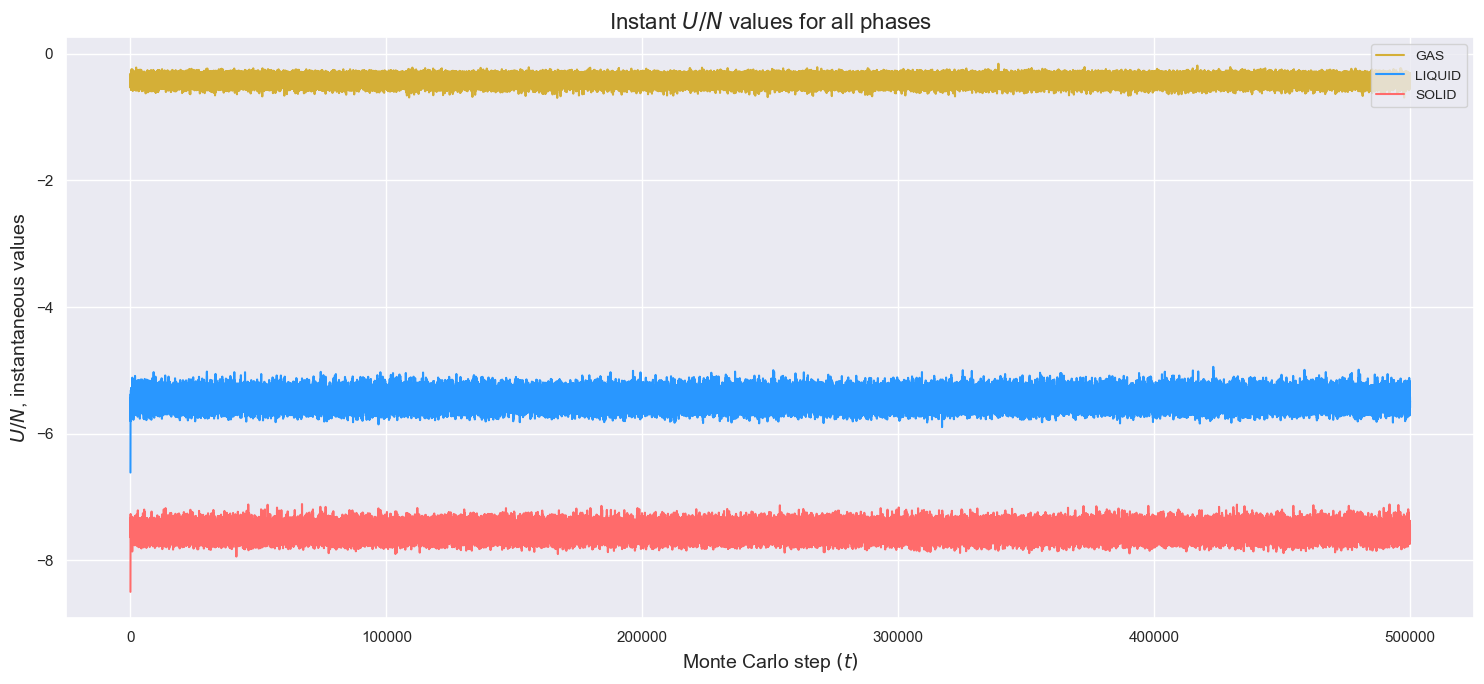

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_theme(style='darkgrid')

# Define the phases and corresponding colors (ensure these are defined if not done earlier)
phases = ['GAS', 'LIQUID', 'SOLID']
colors = ['#d4af37', '#2997ff', '#ff6b6b']  # Make sure the colors correspond to the phases

# Second plot: Visualization of instantaneous values for all phases
fig, ax = plt.subplots(figsize=(15, 7))

# Plot instantaneous values for each phase
for i, phase in enumerate(phases):
    # Path to the potential energy data file for each phase
    path = f'NSL_SIMULATOR/OUTPUT/MC_NVT/AUTOCORRELATION/{phase}/potential_energy.dat'
    
    try:
        # Load the data using Pandas
        df = pd.read_fwf(path, colspecs=[(0, 12), (12, 24), (24, 36), (36, 48)], header=None, skiprows=1)
        df.columns = ['blk', 'average', 'sum_average_per_blk', 'error']  # Add column names
        
        # Use the 'average' column as instantaneous values
        instant_values = df['average']
        ax.plot(instant_values, label=phase, color=colors[i])
    
    # Handle cases where the file is not found
    except FileNotFoundError:
        print(f"File not found: {path}")
    
    # Handle cases where the file is empty or contains invalid data
    except pd.errors.EmptyDataError:
        print(f"Empty or invalid data in file: {path}")

# Formatting the plot for instantaneous values
ax.set_ylabel('$U/N$, instantaneous values', fontsize=14)  # Label for the y-axis
ax.set_xlabel('Monte Carlo step $(t)$', fontsize=14)  # Label for the x-axis
ax.legend(loc='upper right', fontsize=10)  # Place the legend in the upper right
ax.grid(True)  # Add gridlines for better readability
ax.set_title('Instant $U/N$ values for all phases', fontsize=16)  # Set the title of the plot

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Autocorrelation of the data

Another aim of this exercise is to calculate the autocorrelation of the system in order to understand how the data generated using the random number generator influence each other.

In order to grasp the main reason why looking at the autocorrelation of our system is interesting, we must introduce the concept of memory. When talking about complex systems with complex dynamics, the property of memory refers to the ability of past events to influence future dynamics.

The study of autocorrelation is useful to understand if there is any memory effect in the generation of data. A first estimation of autocorrelation comes from the definition of covariance between two statistical variables $x_i$ and $x_k$, and the variance of a single variable:


$$
cov(x_i(t_1),x_k(t_2)) = \langle x_i(t_1)\cdot x_k(t_2) \rangle - \langle x_i(t_1)\rangle\cdot\langle x_k(t_2)\rangle   
$$

$$
var_{[x]} = \sigma^2_x
$$

So the autocorrelation for a time $t'>0$ is defined as:
$$
Autocorrelation[x] = \frac{cov(x(t+t'),x(t))}{var(x(t)}
$$

Thus in the simulation, once we are sure the system has reached equilibrium, we need to measure a quantity X(t) that we are interested in.
In order to obtain accurate averages of quantities, we need to determine how long the simulation should run to get a reliable estimate of their expectation values.
To calculate the correlation time tells us how long it takes for the system to evolve from one state to another that is significantly different from the first. In that case that we have discrete number of measure, we would like to understand after how much step
the measured are not correlated.

The correlation time is the typical time-scale over which the autocorrelation decays. The autocorrelation is expected to decrease exponentially at long times, and we can express this as:
$$
F(t) = e^{(-t/t_c)}
$$

Estimating the time critical $t_c$ I could understand for how long the process maintains a substantial memory of itself. That is a useful information for the technique of data blocking, because with blocks of size much bigger than  one can be confident of having reduced statistical dependence from past blocks.

1. <span style="color:red">Once this instantaneous data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.

We would like to see the auto-correlation between instantaneous data generated by the code.
For this reason, for statistical treatment I calculate the autocorrelation through a function taken from the library`statsmodels.api` called `tsa.acf(data,nlags=max_lag)`: where `data`is the data vector or time series (or in that case a discrete list of measure) for which it is wanted to calculate the autocorrelation whereas `nlags=max_lag` is the parameter specifies the maximum number of lags for which it is wanted to calculate the autocorrelation. If `max_lag` is, for example, 10, the function will compute the autocorrelation up to the 10th lag, meaning it will measure how the values in the time series are correlated with those at 1, 2, 3, ..., 10 positions away.

After I fit the law of exponential auto-correlation to extrapolate the correlation time $t_c$ using the function `curve_fit`from `scipy.optimize`.





t_c GAS: 2.128747737334279
t_c LIQUID: 9.658444909292102
t_c SOLID: 8.469894793779751


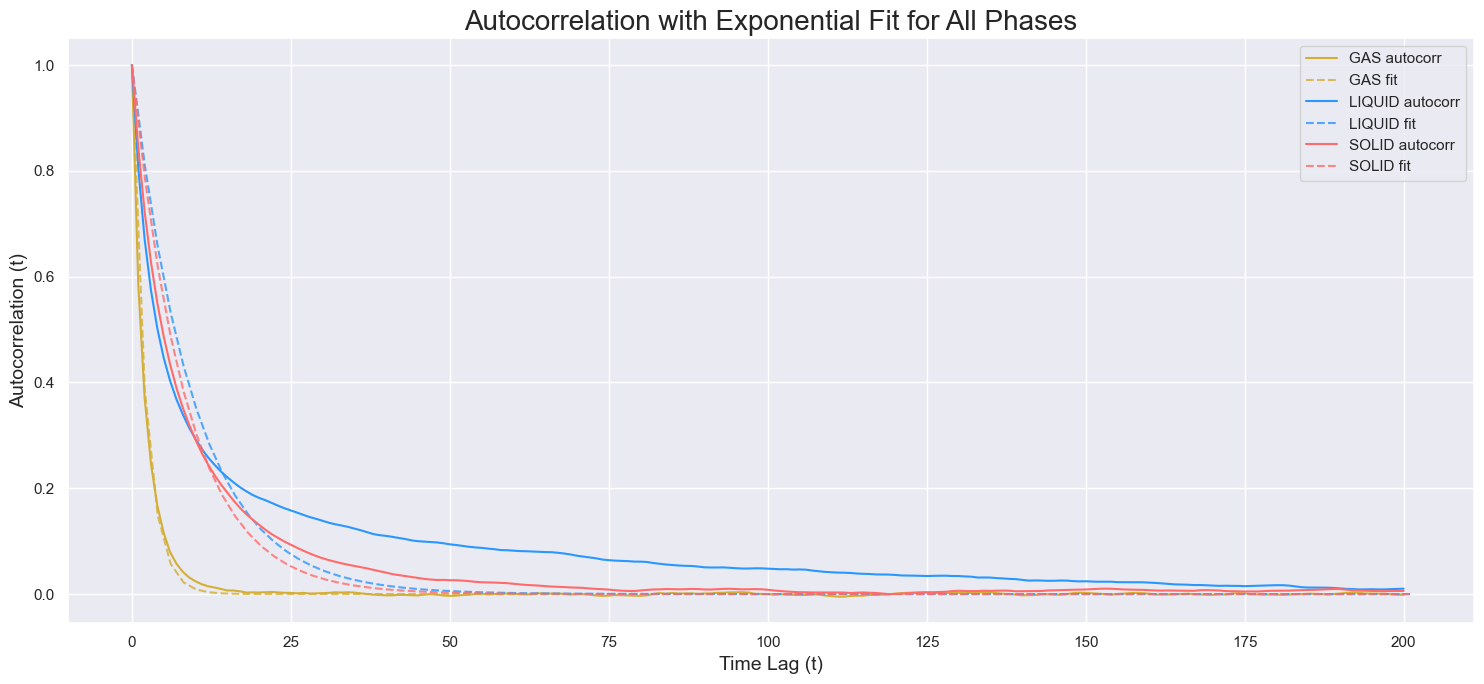

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_theme(style='darkgrid')

# Funzione esponenziale per il fit
def exponential(x, a, b):
    return a * np.exp(-b * x)

# Funzione per calcolare l'autocorrelazione e il fit esponenziale
def plot_autocorrelation(data, label, color, ax):
    max_lag = 200  # Definisci il numero massimo di lag
    
    # Calcolo dell'autocorrelazione
    acorr = sm.tsa.acf(data, nlags=max_lag)

    # Fitting della funzione esponenziale ai dati dell'autocorrelazione
    x = np.arange(len(acorr))
    popt, pcov = curve_fit(exponential, x, acorr, bounds=([1, 0], [np.inf, np.inf]))
    a_fit, b_fit = popt

    # Calcolo del tempo di correlazione critico t_c
    tau = 1 / b_fit
    print(f't_c {label}: {tau}')

    # Generazione dei punti per il fit della funzione esponenziale
    x_fit = np.linspace(0, len(acorr), 100)
    y_fit = exponential(x_fit, a_fit, b_fit)

    # Plot dei dati dell'autocorrelazione e del fit
    ax.plot(x, acorr, label=label + ' autocorr', c=color)
    ax.plot(x_fit, y_fit, label=label + ' fit', c=color, ls='--', alpha=0.8)

# Imposta le fasi e i colori
phases = ['GAS', 'LIQUID', 'SOLID']
colors = ['#d4af37', '#2997ff', '#ff6b6b']

# Crea la figura per il plot singolo delle autocorrelazioni e del fit
fig, ax = plt.subplots(figsize=(15, 7))

# Ciclo per caricare i dati e calcolare l'autocorrelazione per ciascuna fase
for i, phase in enumerate(phases):
    path = f'NSL_SIMULATOR/OUTPUT/MC_NVT/AUTOCORRELATION/{phase}/potential_energy.dat'
    
    # Carica i dati usando Pandas
    df = pd.read_fwf(path, colspecs=[(0, 12), (12, 24), (24, 36), (36, 48)], header=None, skiprows=1)
    df.columns = ['blk', 'average', 'sum_average_per_blk', 'error']  # Aggiungi i nomi delle colonne
    
    # Usa i valori istantanei dalla colonna 'average'
    instant_values = df['average']

    # Calcola e plotta l'autocorrelazione e il fit su un unico plot
    plot_autocorrelation(instant_values, phase, colors[i], ax)

# Formattazione del grafico delle autocorrelazioni e del fit
ax.set_ylabel('Autocorrelation (t)',fontsize =14)
ax.set_xlabel('Time Lag (t)', fontsize =14)
ax.grid(True)
ax.legend()

# Imposta il titolo principale
plt.title('Autocorrelation with Exponential Fit for All Phases', fontsize=20)
plt.tight_layout()
plt.show()






What we can observed is that the result follow and exponential behaviour and thus autocorrelation drops after few Lag.
In particular for Gas Phase, the drops is faster probably because is a much more disorder system than the solid and the liquid one.
The result are:
- $t_c$ GAS: 2.13
- $t_c$ LIQUID: 9.65
- $t_c$ SOLID: 8.47


## A first solution: Data Blocking
Autocorrelation is clearly useful for understanding if a system based on random generator data has memory. This is important because if the data collected are correlated, the statistical error could be underestimated.
To address this issue, all exercises up to now have adopted the data blocking technique. This technique involves dividing a set of measurements into blocks, averaging each block, calculating the progressive average, and then determining the uncertainty on the progressive average of the blocks.
Given a collection of `M`data of a quantities $g$ and divide it in `N` group made of `L` elementes, permit to have this media:

$$
\langle g\rangle = \frac{1}{M}\cdot \sum_{i=1}^{M}g_i
$$

where $g_i$ is the mean in a block of L elements. 
While the error:
$$
\sigma_g = \sqrt{\frac{1}{N-1}\cdot \left[\frac{1}{N}\cdot \sum_{i=1}^{N}g_i^2 - \left(\frac{1}{N}\cdot \sum_{i=1}^{N} g_i\right)^2\right]}
$$

Why is this done? Data blocking allows us to transform a list of possibly correlated data into a set of blocks that are uncorrelated with each other, thus enabling the Central Limit Theorem to apply and making the average value more accurate.


Therefore, the question arises: how large should the blocks be to ensure that they are uncorrelated and to avoid underestimating the uncertainty? This is the objective of the following part of the exercise.



2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

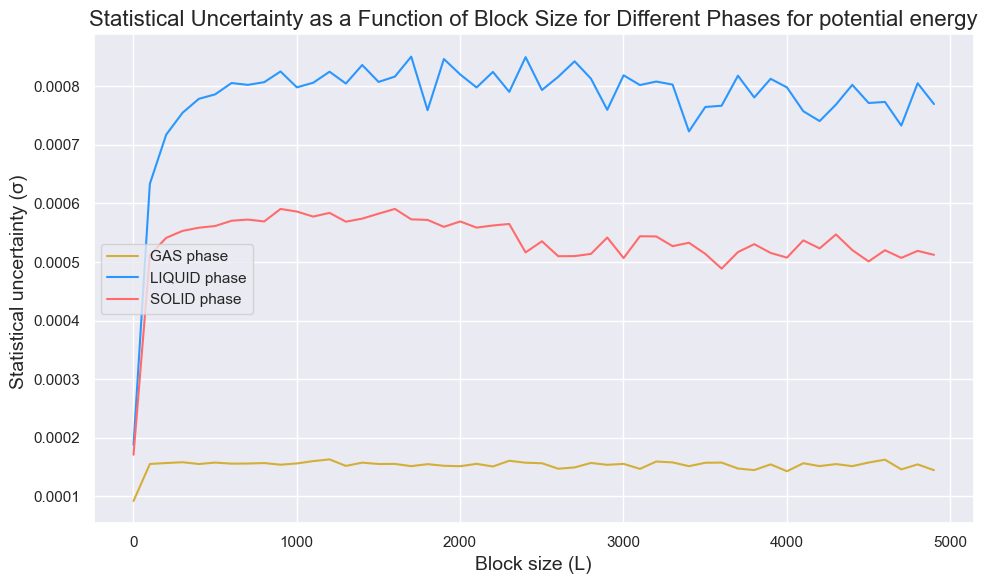

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate block averages and errors
def block_data(data, block_size):
    # Split data into blocks
    n_blocks = len(data) // block_size
    blocks = np.array_split(data[:n_blocks*block_size], n_blocks)
    
    # Calculate the block averages
    block_means = np.array([np.mean(block) for block in blocks])
    
    # Calculate the overall mean and the variance
    overall_mean = np.mean(block_means)
    squared_mean = np.mean(block_means**2)
    
    # Calculate the error on the mean using the data blocking formula
    if n_blocks > 1:
        error = np.sqrt((squared_mean - overall_mean**2) / (n_blocks - 1))
    else:
        error = np.nan  # Cannot calculate error with fewer than 2 blocks
    
    return error

# Phases to process
phases = ['GAS', 'LIQUID', 'SOLID']
colors = ['#d4af37', '#2997ff', '#ff6b6b']

# Initialize the figure
plt.figure(figsize=(10, 6))

# Loop through each phase
for i, phase in enumerate(phases):
    # Load the data for each phase
    path = f'NSL_SIMULATOR/OUTPUT/MC_NVT/AUTOCORRELATION/{phase}/potential_energy.dat'
    df = pd.read_fwf(path, colspecs=[(0, 12), (12, 24), (24, 36), (36, 48)], header=None, skiprows=1)
    df.columns = ['blk', 'average', 'sum_average_per_blk', 'error']
    
    # Use the 'average' column for U/N
    data = df['average'].values
    
    # Initialize lists to store block sizes and corresponding errors
    block_sizes = []
    errors = []

    # Loop over different block sizes (starting from L=2 to 5000)
    max_block_size = 5000
    for block_size in range(2, max_block_size + 1, 100):  # Vary block size from 2 to 5000
        error = block_data(data, block_size)
        block_sizes.append(block_size)
        errors.append(error)
    
    # Convert to numpy arrays for plotting
    block_sizes = np.array(block_sizes)
    errors = np.array(errors)
    
    # Plot the errors for this phase as a function of block size
    plt.plot(block_sizes, errors, '-', label=f'{phase} phase', color=colors[i])

# Plot formatting
plt.xlabel('Block size (L)', fontsize=14)
plt.ylabel('Statistical uncertainty (σ) ', fontsize=14)
plt.title('Statistical Uncertainty as a Function of Block Size for Different Phases for potential energy', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


 The results show, as expected, that as the block size increases, 
 the error remains constant and is no longer underestimated as it is 
 when there are only a few blocks. This behavior occurs for each phase. 
 Additionally, it can be observed that by increasing the number of estimates 
 within each block L = M/N (with M fixed), one approaches the true statistical 
 error due to the use of a Markov chain. Once this limit is reached, further 
 increasing L should no longer affect the error. This is because the Central 
 Limit Theorem is satisfied: increasing L changes the distribution of $g_i$ 
 (which becomes narrower), but not the error $σ_g$, since N becomes smaller.



### Exercise 07.3

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code</span>: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

The algorithmn for calculating the pair distribution function come from the deduction that g(r) could be calcolate throug this formula:

$$
g(r) = \langle g(\vec r) \rangle _{r \in [r; r+dr],\theta \in [0; \pi],\phi \in [0; 2\pi]} = \frac{1}{\rho N \Delta V(r)}\cdot \langle \sum\sum_{i ≠ j}^{N}\delta(|\vec r|-|\vec r_i - \vec r_j|)\rangle
$$

In practice, during the simulation, I write a function that "fill" a histogram by increasing the bin count by 2 at  r  whenever two particles are found at a distance between  r  and  r + dr. Finally I normalized for the number of particle N, the density rho and the volume that depend on r taken. In the code I write:

````cpp

 if (_measure_penergy or _measure_pressure or _measure_gofr) {
    for (int i=0; i<_npart-1; i++){
      for (int j=i+1; j<_npart; j++){
        distance(0) = this->pbc( _particle(i).getposition(0,true) - _particle(j).getposition(0,true), 0);
        distance(1) = this->pbc( _particle(i).getposition(1,true) - _particle(j).getposition(1,true), 1);
        distance(2) = this->pbc( _particle(i).getposition(2,true) - _particle(j).getposition(2,true), 2);
        dr = sqrt( dot(distance,distance) );
        if(_measure_gofr && dr < _halfside.min()) {_measurement(_index_gofr + int(floor(dr/_bin_size))) += 2.;}

and [...]
        
if (_measure_gofr) {
    for (int i = 0 ; i < _n_bins; i++){
      _measurement(_index_gofr+ i) /= _rho *_npart*(4./3.)* M_PI * (pow(_bin_size*(double)(i+1.),3)-pow(_bin_size*(double)i,3));
      
    }
  }

````

Below there are the graphic of g(r) for each phase.


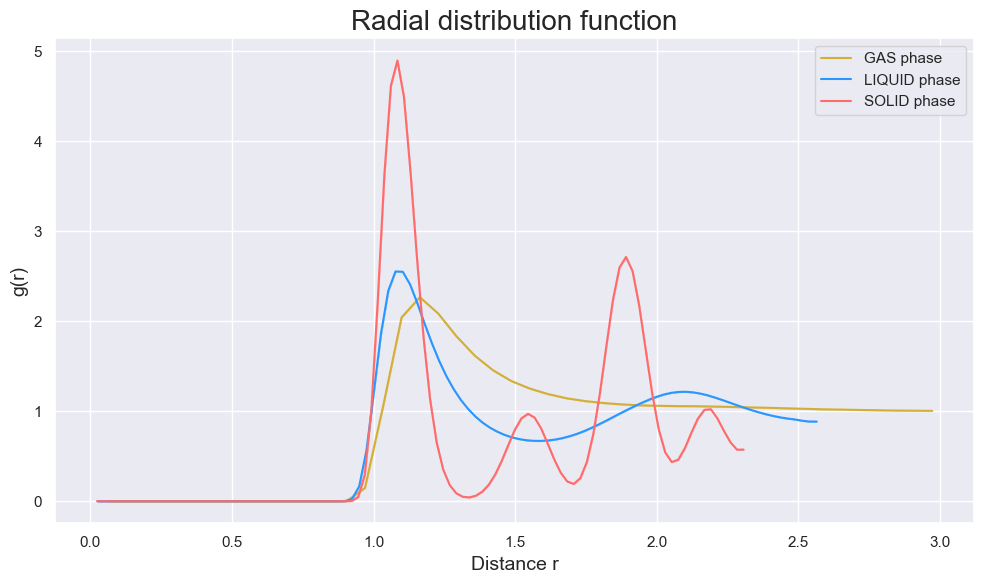

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Phases to process
phases = ['GAS', 'LIQUID', 'SOLID']
colors = ['#d4af37', '#2997ff', '#ff6b6b']

# Initialize the figure
plt.figure(figsize=(10, 6))

# Loop through each phase
for i, phase in enumerate(phases):
    # Load the data for each phase
    path = f'NSL_SIMULATOR/OUTPUT/MC_NVT/{phase}/gofr.dat'
    df = pd.read_fwf(path, colspecs=[(0, 12), (12, 24), (24, 36)], header=None, skiprows=1)
    df.columns = ['distance', 'average', 'error']
    
    # Filter the data to include only distances where r < 3
    df_filtered = df[df['distance'] < 3]
    
    # Use the 'average' column for U/N
    data = df_filtered['average'].values
    
    # Plot the data with a continuous line and error bars
    plt.plot(df_filtered['distance'], data, '-', label=f'{phase} phase', color=colors[i])
    plt.fill_between(df_filtered['distance'], data - df_filtered['error'], data + df_filtered['error'], color=colors[i], alpha=0.3)

# Plot formatting
plt.xlabel('Distance r', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('Radial distribution function', fontsize=20)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


We can deduce some information from this graph. For each phase, at distances  r in reduced units between approximately  0  and 1,  g(r) is zero, which means that particles cannot overlap with each other, there is and an hardcore region where potential diverges. For every phase, there is a peak around $r \approx 1$; this distance is where particles tend to attract each other which means that particle show a structure with a shell. According to a supposition to have a crystal structure, in the solid phase, however, there is a more ordered structure, presenting a second peak around $ r \approx 2$, which might indicate the second boundary of the crystal, and an intermediate peak, which could correspond to the diagonal. There is also a structure less defined for the liquid phase.

The gaseous phase, after this first peak, distributes uniformly. Appropriately, after a peak with g(r) > 1, indicating attraction between particles, a peak with  g(r) < 1  follows. This behavior is observed in the liquid and solid phases, where particles tend to repel each other.


### Exercise 07.4

By means of your upgraded NSL simulator code, equilibrate and <span style="color:red">perform MC NVT simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... <span style="color:red"> and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.</span>

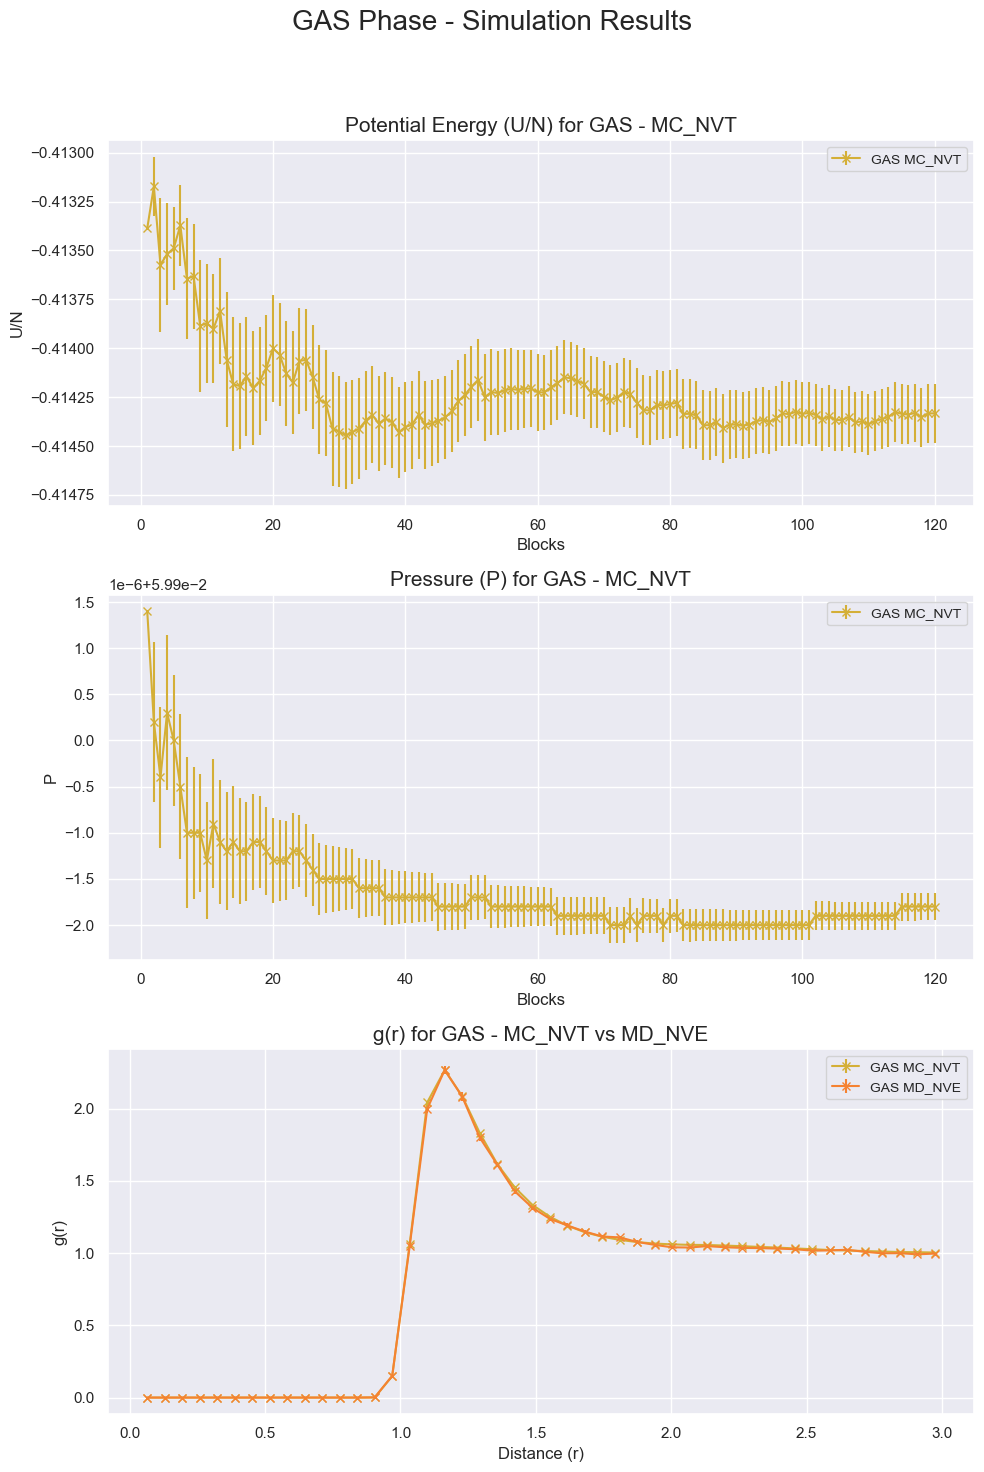

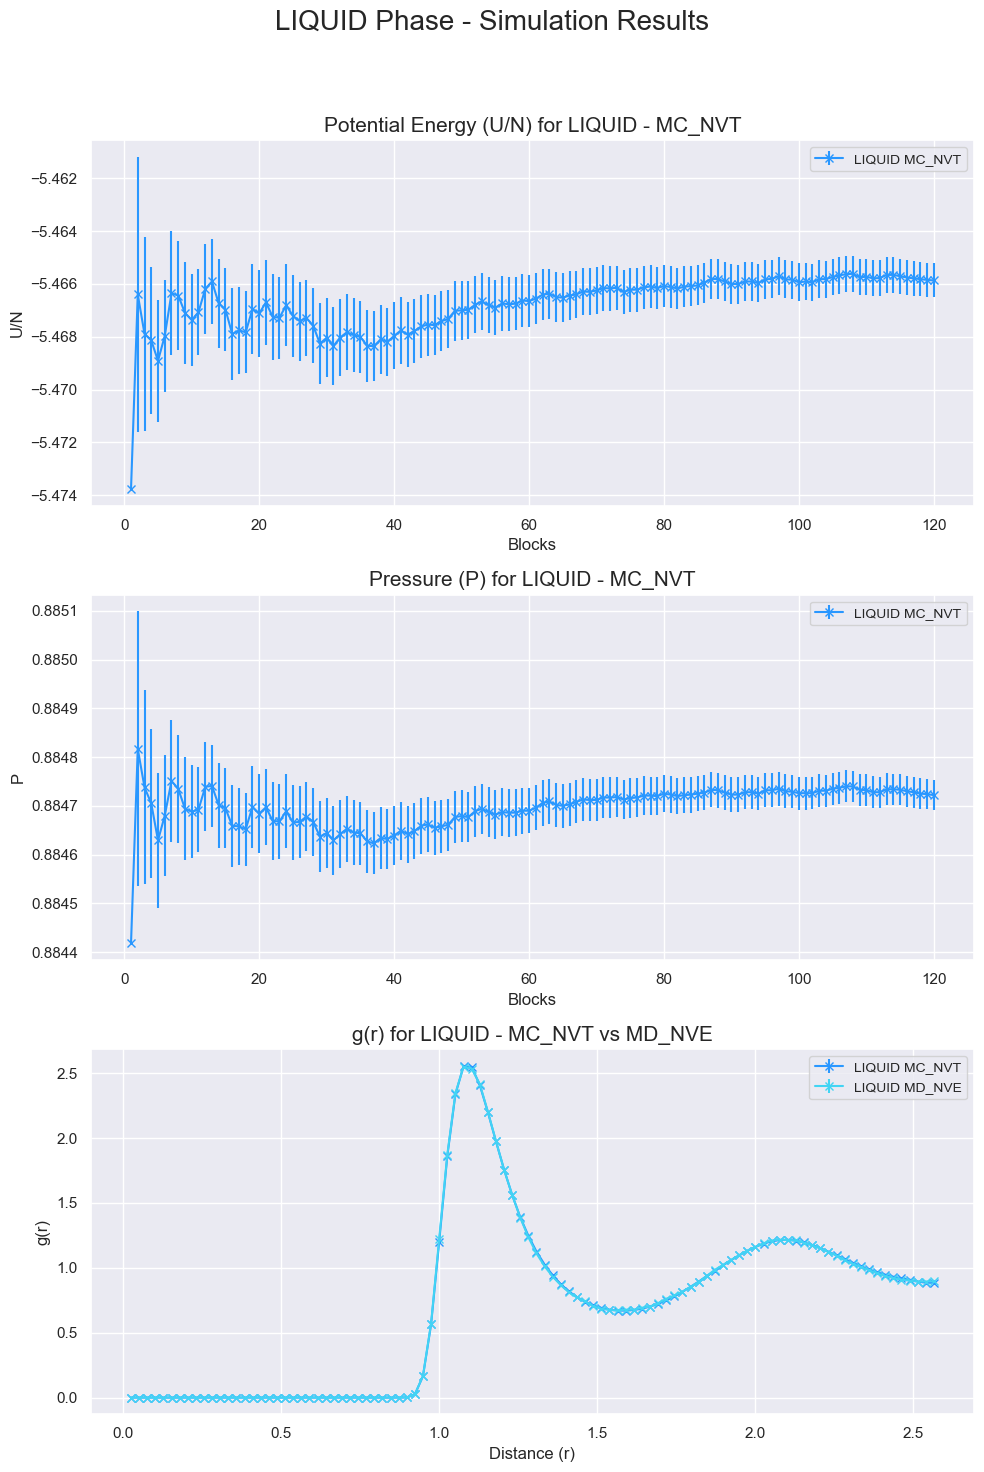

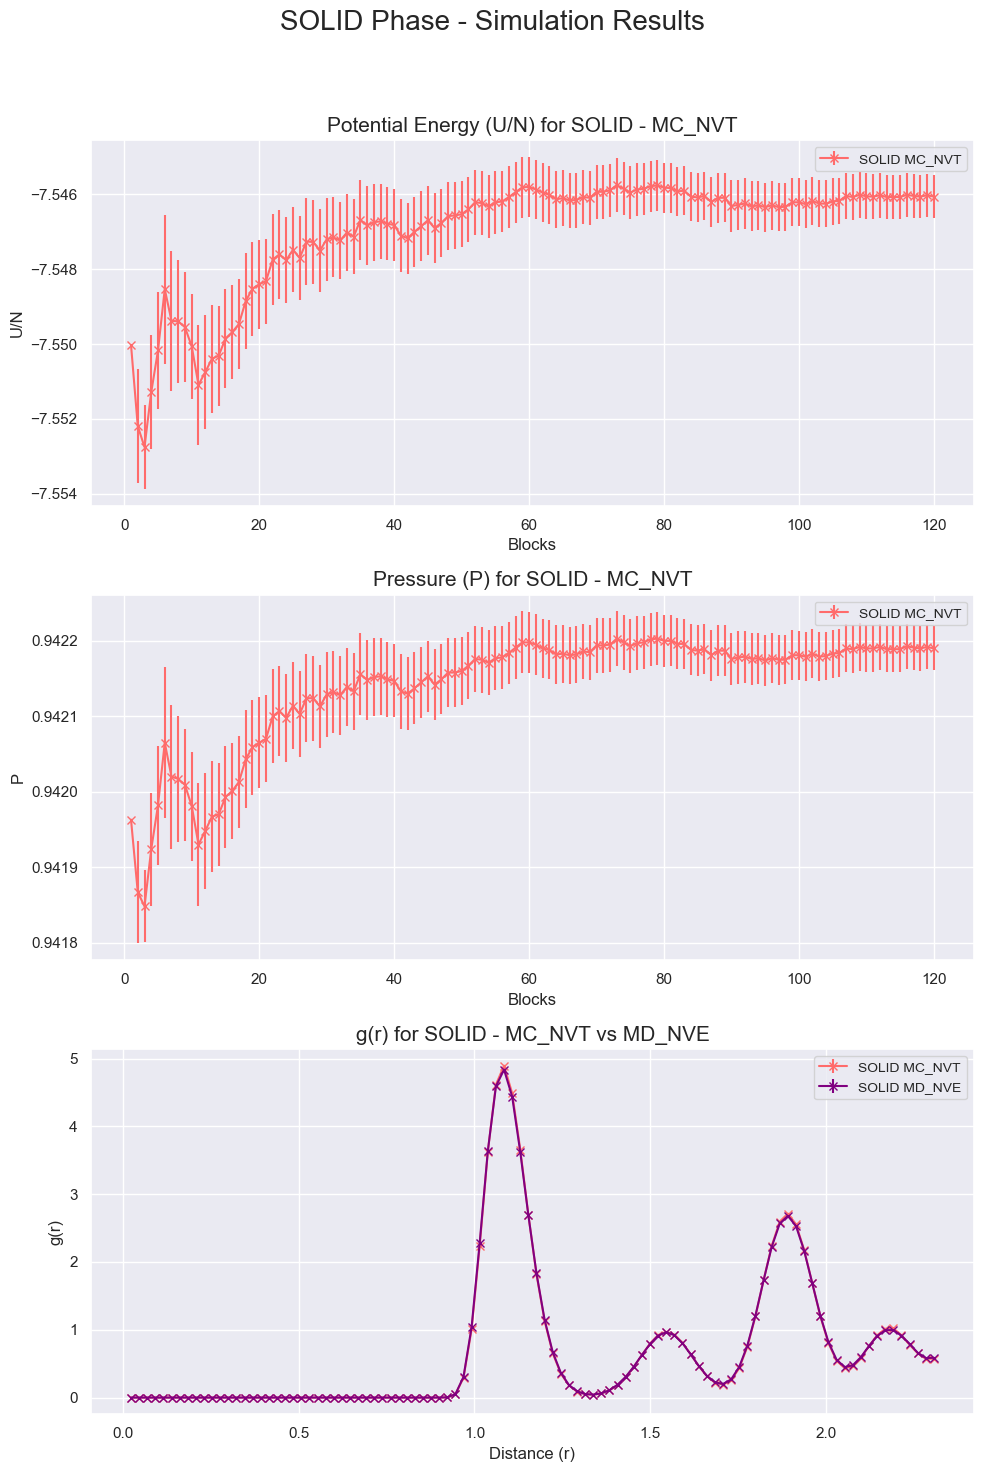

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definisci le fasi e i metodi
phases = ['GAS', 'LIQUID', 'SOLID']
methods = ['MC_NVT', 'MD_NVE']

# Colori distinti per ogni fase e metodo
colors = {
    'GAS_MC_NVT': '#d4af37', 'GAS_MD_NVE': '#f58231',  # Oro e arancione per GAS
    'LIQUID_MC_NVT': '#2997ff', 'LIQUID_MD_NVE': '#42d4f4',  # Blu e azzurro per LIQUID
    'SOLID_MC_NVT': '#ff6b6b', 'SOLID_MD_NVE': '#800080'  # Rosso e viola per SOLID
}

# Loop attraverso ogni fase per generare tre grafici distinti
for phase in phases:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))  # Tre grafici in verticale
    fig.suptitle(f'{phase} Phase - Simulation Results', fontsize=20)
    plt.subplots_adjust(hspace=0.4)

    # Plot 1: Potential Energy (solo MC_NVT)
    try:
        path_potential = f'NSL_SIMULATOR/OUTPUT/MC_NVT/{phase}/potential_energy.dat'
        df_potential = pd.read_fwf(path_potential, colspecs=[(0, 12), (12, 24), (24, 36), (36, 48)], header=None, skiprows=1)
        df_potential.columns = ['blk', 'average', 'sum_average_per_blk', 'error']
        ax1.errorbar(df_potential['blk'], df_potential['sum_average_per_blk'], yerr=df_potential['error'],
                     label=f'{phase} MC_NVT', color=colors[f'{phase}_MC_NVT'], linestyle='-', marker='x')
    except FileNotFoundError:
        print(f'File not found: {path_potential}')

    # Configurazione del grafico per l'energia potenziale
    ax1.set_title(f'Potential Energy (U/N) for {phase} - MC_NVT', fontsize=15)
    ax1.set_xlabel('Blocks', fontsize=12)
    ax1.set_ylabel('U/N', fontsize=12)
    ax1.grid(True)
    ax1.legend(fontsize=10)

    # Plot 2: Pressure (solo MC_NVT)
    try:
        path_pressure = f'NSL_SIMULATOR/OUTPUT/MC_NVT/{phase}/pressure.dat'
        df_pressure = pd.read_fwf(path_pressure, colspecs=[(0, 12), (12, 24), (24, 36), (36, 48)], header=None, skiprows=1)
        df_pressure.columns = ['blk', 'average', 'sum_average_per_blk', 'error']
        ax2.errorbar(df_pressure['blk'], df_pressure['sum_average_per_blk'], yerr=df_pressure['error'],
                     label=f'{phase} MC_NVT', color=colors[f'{phase}_MC_NVT'], linestyle='-', marker='x')
    except FileNotFoundError:
        print(f'File not found: {path_pressure}')

    # Configurazione del grafico per la pressione
    ax2.set_title(f'Pressure (P) for {phase} - MC_NVT', fontsize=15)
    ax2.set_xlabel('Blocks', fontsize=12)
    ax2.set_ylabel('P', fontsize=12)
    ax2.grid(True)
    ax2.legend(fontsize=10)

    # Plot 3: g(r) per entrambi i metodi
    for method in methods:
        try:
            path_gofr = f'NSL_SIMULATOR/OUTPUT/{method}/{phase}/gofr.dat'
            df_gofr = pd.read_fwf(path_gofr, colspecs=[(0, 12), (12, 24), (24, 36)], header=None, skiprows=1)
            df_gofr.columns = ['distance', 'average', 'error']
            
            # Filtra per distanze minori di 3
            df_gofr_filtered = df_gofr[df_gofr['distance'] < 3]
            ax3.errorbar(df_gofr_filtered['distance'], df_gofr_filtered['average'], yerr=df_gofr_filtered['error'],
                         label=f'{phase} {method}', color=colors[f'{phase}_{method}'], linestyle='-', marker='x')
        except FileNotFoundError:
            print(f'File not found: {path_gofr}')

    # Configurazione del grafico per g(r)
    ax3.set_title(f'g(r) for {phase} - MC_NVT vs MD_NVE', fontsize=15)
    ax3.set_xlabel('Distance (r)', fontsize=12)
    ax3.set_ylabel('g(r)', fontsize=12)
    ax3.grid(True)
    ax3.legend(fontsize=10)

    # Aggiusta il layout per evitare sovrapposizioni
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Mostra i grafici per ogni fase
    plt.show()


Although two different sampling methods were used, the results from the graph show that the measurements are compatible with each other for all the requested quantities.
To see this better I could plot the difference between the values of two type of sampling g(r):

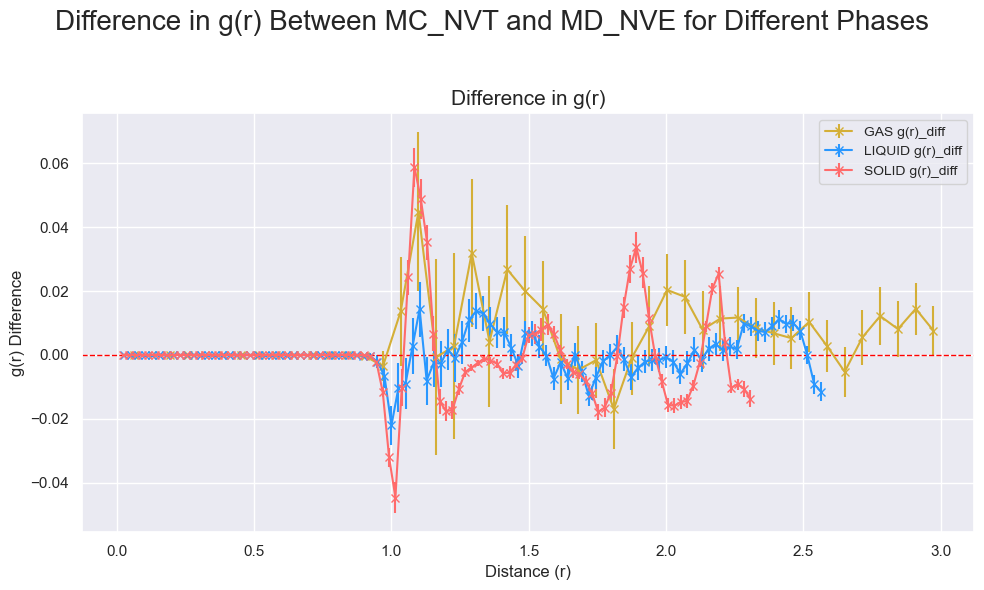

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fasi e colori distinti
phases = ['GAS', 'LIQUID', 'SOLID']
colors = {'GAS': '#d4af37', 'LIQUID': '#2997ff', 'SOLID': '#ff6b6b'}  # Oro, blu, rosso

# Configura la figura e l'asse
fig, ax = plt.subplots(figsize=(10, 6))  # Un solo grafico
fig.suptitle('Difference in g(r) Between MC_NVT and MD_NVE for Different Phases', fontsize=20)
plt.subplots_adjust(hspace=0.4)

# Loop per calcolare e plottare le differenze di g(r) per ogni fase
for phase in phases:
    try:
        # Leggi i dati di g(r) per MC_NVT
        path_gofr_MC = f'NSL_SIMULATOR/OUTPUT/MC_NVT/{phase}/gofr.dat'
        df_gofr_MC = pd.read_fwf(path_gofr_MC, colspecs=[(0, 12), (12, 24), (24, 36)], header=None, skiprows=1)
        df_gofr_MC.columns = ['distance', 'average', 'error']
        
        # Leggi i dati di g(r) per MD_NVE
        path_gofr_MD = f'NSL_SIMULATOR/OUTPUT/MD_NVE/{phase}/gofr.dat'
        df_gofr_MD = pd.read_fwf(path_gofr_MD, colspecs=[(0, 12), (12, 24), (24, 36)], header=None, skiprows=1)
        df_gofr_MD.columns = ['distance', 'average', 'error']
        
        # Filtra i dati per distanze minori di 3
        df_gofr_MC_filtered = df_gofr_MC[df_gofr_MC['distance'] < 3]
        df_gofr_MD_filtered = df_gofr_MD[df_gofr_MD['distance'] < 3]

        # Allinea i dati sui due DataFrame in base alla lunghezza minima
        min_length = min(len(df_gofr_MC_filtered), len(df_gofr_MD_filtered))
        df_gofr_MC_filtered = df_gofr_MC_filtered.iloc[:min_length]
        df_gofr_MD_filtered = df_gofr_MD_filtered.iloc[:min_length]

        # Calcola la differenza tra g(r) e l'errore combinato
        gofr_diff = df_gofr_MC_filtered['average'] - df_gofr_MD_filtered['average']
        gofr_diff_error = np.sqrt(df_gofr_MC_filtered['error']**2 + df_gofr_MD_filtered['error']**2)

        # Plotta la differenza per g(r)
        ax.errorbar(df_gofr_MC_filtered['distance'], gofr_diff, yerr=gofr_diff_error, 
                     label=f'{phase} g(r)_diff', color=colors[phase], linestyle='-', marker='x')
        
    except FileNotFoundError:
        print(f'gofr files not found for {phase}')

# Configura il grafico
ax.axhline(0, color='red', linestyle='--', linewidth=1)  # Linea rossa a y=0 per indicare la differenza zero
ax.set_title('Difference in g(r)', fontsize=15)
ax.set_xlabel('Distance (r)', fontsize=12)
ax.set_ylabel('g(r) Difference', fontsize=12)
ax.grid(True)
ax.legend(fontsize=10)

# Aggiusta il layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Mostra il grafico
plt.show()


The two measure of `g(r)` look similar to each other for the MD_NVE and MC_NVT methods, with a precision of 0.01 in the measured quantities. The two sampling methods are compatible and equally valid since they lead to the same results.